In [8]:
import pickle
import math
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.decomposition import PCA

In [2]:
import os
import sys
module_path = os.path.abspath('/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis')
if module_path not in sys.path:
    sys.path.append(module_path)

import chrysalis as ch

plt.rcParams['svg.fonttype'] = 'none'

data_path = '/mnt/c/Users/demeter_turos/PycharmProjects/chrysalis/data/xenium_human_breast_cancer/'

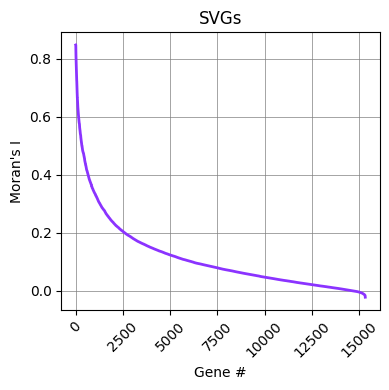

In [3]:
# read file and do PCA
adata = sc.read_h5ad(data_path + 'visium_sample.h5ad')

ch.plot_svgs(adata)
plt.show()

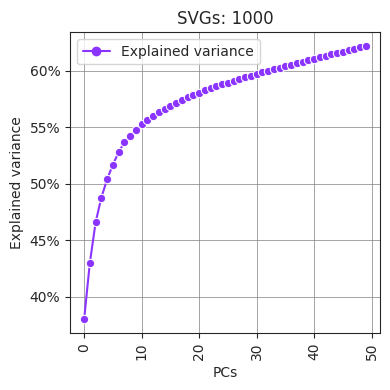

In [4]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)

ch.pca(adata, n_pcs=50)

ch.plot_explained_variance(adata)
plt.show()

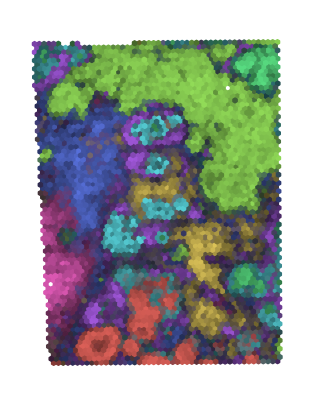

In [5]:
ch.aa(adata, n_pcs=20, n_archetypes=8)
ch.plot(adata, dim=8)
plt.show()

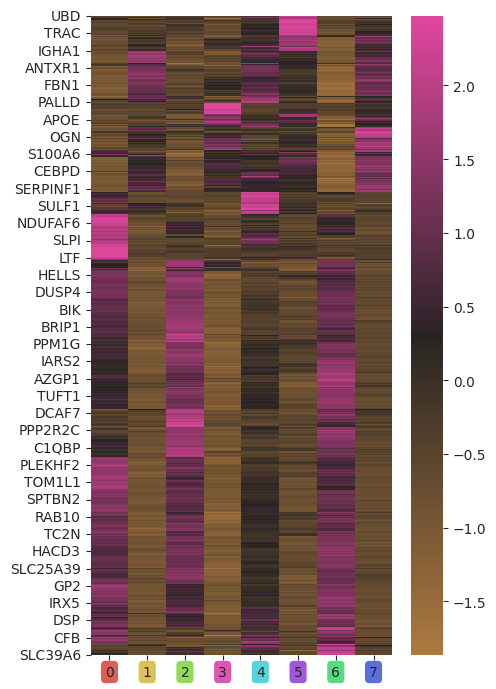

In [6]:
ch.plot_heatmap(adata)
plt.show()

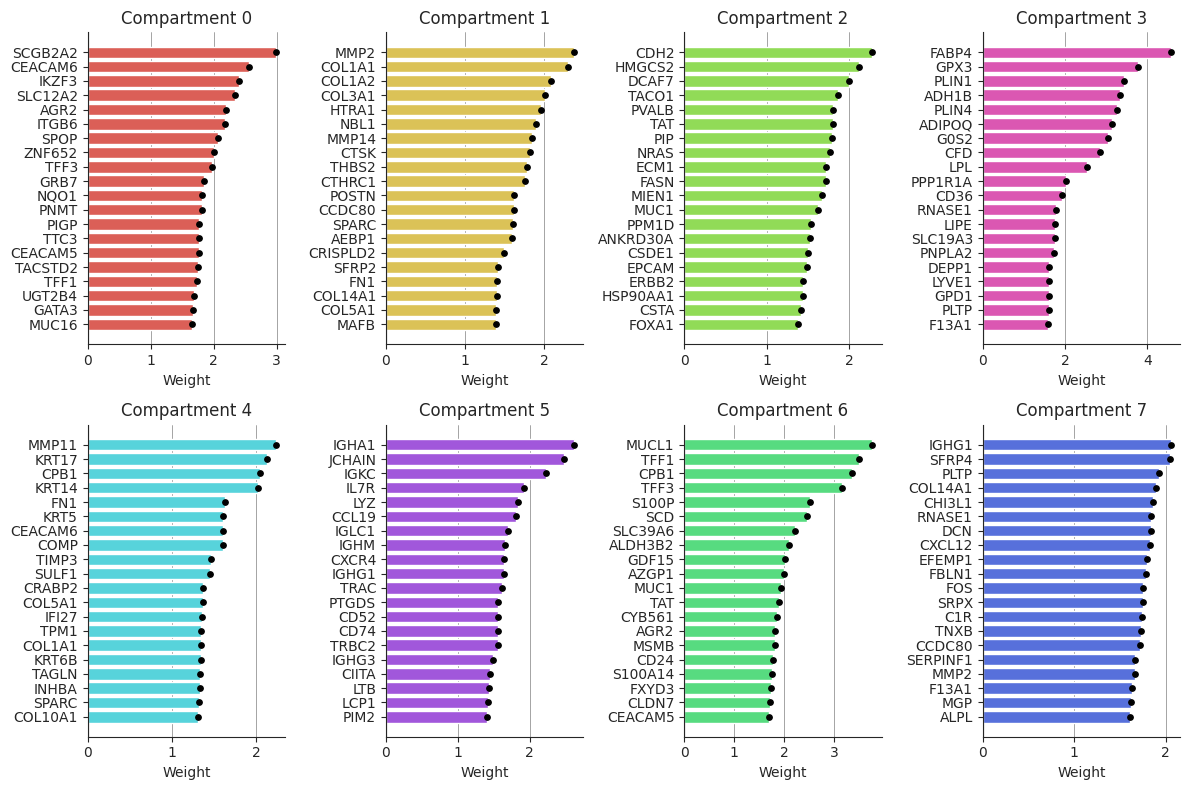

In [7]:
ch.plot_weights(adata)
plt.show()

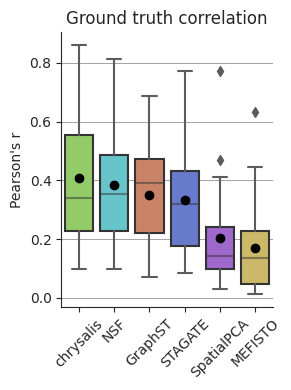

In [10]:
# add cell type abundances

di = {'B_Cells': 'B cell', 'CD4+_T_Cells': 'CD4+ T cell', 'CD8+_T_Cells': 'CD8+ T cell', 'DCIS_1': 'DCIS #1',
      'DCIS_2': 'DCIS #2',
       'Endothelial': 'Endothelial cell', 'IRF7+_DCs': 'IRF7+ Dendritic cell', 'Invasive_Tumor': 'Invasive tumor',
      'LAMP3+_DCs': 'LAMP3+ Dendritic cell',
       'Macrophages_1': 'Macrophage #1', 'Macrophages_2': 'Macrophage #2', 'Mast_Cells': 'Mast cell',
      'Myoepi_ACTA2+': 'ACTA2+ Myoepithelial cell',
       'Myoepi_KRT15+': 'KRT15+ Myoepithelial cell', 'Perivascular-Like': 'Perivascular-like',
      'Prolif_Invasive_Tumor': 'Proliferative inv. tumor',
       'Stromal': 'Stromal cell', 'Stromal_&_T_Cell_Hybrid': 'Stromal & T cell',
      'T_Cell_&_Tumor_Hybrid': 'T cell & tumor',
       'Unlabeled': 'Unlabeled'}

cell_type_df = pd.read_csv(data_path + 'cell_type_abundance.csv', index_col=0)
cell_type_df = cell_type_df.rename(columns=di)

adata.obs[cell_type_df.columns] = cell_type_df
cell_type_df = adata.obs[cell_type_df.columns]

# scanpy PCA

sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=1000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)

scanpy_df = pd.DataFrame(adata.obsm['X_pca'])

# SpatialPCA

spapca_df = pd.read_csv(data_path + 'spatialpca/spatial_pcs.csv', index_col=0).T

# MEFISTO

meph_df = pd.read_csv(data_path + 'mefisto/factors.csv', index_col=0)

# STAGATE results

stagate_df = pd.read_csv(data_path + 'stagate_breast_cancer.csv', index_col=0)

# NSF results


file = open(data_path + 'human_breast_cancer_nsf.pkl', 'rb')
data = pickle.load(file)
file.close()


def transform_coords(X):
    # code from nsf github
    X[:, 1] = -X[:, 1]
    xmin = X.min(axis=0)
    X -= xmin
    x_gmean = np.exp(np.mean(np.log(X.max(axis=0))))
    X *= 4 / x_gmean
    return X - X.mean(axis=0)


X = adata.obsm["spatial"].copy().astype('float32')
tcoords = transform_coords(X)

pair_idx = []
for xy in data['positions']:
    distances = [math.dist([xy[0], xy[1]], [idx[0], idx[1]]) for idx in tcoords]
    pair_idx.append(np.argmin(distances))

nsf_df = pd.DataFrame(data=np.zeros([len(adata), data['factors']['factors'].shape[1]]))
for idx, i in enumerate(pair_idx):
    nsf_df.iloc[i, :] = data['factors']['factors'][idx, :]
nsf_df.index = adata.obs.index

# GraphST results

graphst_df = pd.read_csv(data_path + 'graphst_breast_cancer.csv', index_col=0)
graphst_df.index = adata.obs.index

pca = PCA(n_components=20, svd_solver='arpack', random_state=42)
graphst_pcs = pca.fit_transform(graphst_df)
graphst_pcs_df = pd.DataFrame(data=graphst_pcs, index=graphst_df.index)

adata.obs['graphst'] = graphst_pcs[:, 3]

# avg correlations for the methods

compartment_df = pd.DataFrame(data=adata.obsm['chr_aa'],
                              index=adata.obs_names,
                              columns=range(adata.obsm['chr_aa'].shape[1]))

mdf_dict = {
    'chrysalis': [compartment_df, '#91db57'],
    'NSF': [nsf_df, '#57d3db'],
    'STAGATE': [stagate_df, '#5770db'],
    'MEFISTO': [meph_df, '#dbc257'],
    'SpatialPCA': [spapca_df, '#a157db'],
    'GraphST': [graphst_pcs_df, '#db7c57']
    # 'scanpy': [adata.obs['sc_gc'], '#57d3db'],
}

method_cdf = pd.DataFrame(columns=mdf_dict.keys(), index=cell_type_df.columns)
for k, v in mdf_dict.items():

    corr_matrix = np.empty((len(cell_type_df.columns), len(v[0].columns)))

    for i, col1 in enumerate(cell_type_df.columns):
        for j, col2 in enumerate(v[0].columns):
            corr, _ = pearsonr(cell_type_df[col1], v[0][col2])
            corr_matrix[i, j] = corr

    corr_df = pd.DataFrame(data=corr_matrix, index=cell_type_df.columns, columns=v[0].columns)
    method_cdf[k] = corr_df.T.max()

method_cdf = method_cdf.reindex(method_cdf.mean().sort_values(ascending=False).index, axis=1)
colors = [mdf_dict[k][1] for k in method_cdf.columns]

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.grid(axis='both', linestyle='-', linewidth='0.5', color='grey')
ax.set_axisbelow(True)
sns.boxplot(method_cdf, palette=colors, boxprops={'edgecolor': "0.2"}, medianprops={"color": "0.2", 'alpha': 0.5},
            showmeans=True, meanprops={'marker': 'o', 'markerfacecolor': 'black', 'markeredgecolor': 'black'})
ax.set_title('Ground truth correlation')
ax.set_ylabel("Pearson's r")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()